## Question 3: Implementation and experimentation


### Question 3.2

In [40]:
# Imports
import torch, os
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
import torchvision.transforms as transforms
device = "cuda" if torch.cuda.is_available() else "cpu"

# Fix random seed, DO NOT CHANGE
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [47]:
class VGG16(nn.Module):
  """This class implements the VGG-16 architecture in PyTorch"""

  def __init__(self, activation_str="relu"):
    """
      Constructor for the VGG16 class.

      activation_str: string, default "relu"
        Activation function to use.

    """
    super(VGG16, self).__init__()

    self.n_classes = 10
    self.activation_str = activation_str

    self.conv_layer_1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
    self.conv_layer_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
    self.conv_layer_3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
    self.conv_layer_4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
    self.conv_layer_5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
    self.conv_layer_6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
    self.conv_layer_7 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
    self.conv_layer_8 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)
    self.conv_layer_9 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
    self.conv_layer_10 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
    self.conv_layer_11 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
    self.conv_layer_12 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
    self.conv_layer_13 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)

    # Add 2D batch normalization after every convolutional layer
    self.conv_layer_1_bn = nn.BatchNorm2d(num_features=64)
    self.conv_layer_2_bn = nn.BatchNorm2d(num_features=64)
    self.conv_layer_3_bn = nn.BatchNorm2d(num_features=128)
    self.conv_layer_4_bn = nn.BatchNorm2d(num_features=128)
    self.conv_layer_5_bn = nn.BatchNorm2d(num_features=256)
    self.conv_layer_6_bn = nn.BatchNorm2d(num_features=256)
    self.conv_layer_7_bn = nn.BatchNorm2d(num_features=256)
    self.conv_layer_8_bn = nn.BatchNorm2d(num_features=512)
    self.conv_layer_9_bn = nn.BatchNorm2d(num_features=512)
    self.conv_layer_10_bn = nn.BatchNorm2d(num_features=512)
    self.conv_layer_11_bn = nn.BatchNorm2d(num_features=512)
    self.conv_layer_12_bn = nn.BatchNorm2d(num_features=512)
    self.conv_layer_13_bn = nn.BatchNorm2d(num_features=512)

    self.max_pool_layer_1 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.max_pool_layer_2 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.max_pool_layer_3 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.max_pool_layer_4 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.max_pool_layer_5 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.fc_1 = nn.Linear(in_features=25088, out_features=4096) # flattened size is 512×7×7=25088
    self.fc_2 = nn.Linear(in_features=4096, out_features=4096)
    self.fc_3 = nn.Linear(in_features=4096, out_features=self.n_classes)

    # Initialize the weights of each trainable layer of your network using xavier_normal initialization
    init.xavier_uniform_(self.conv_layer_1.weight)
    init.xavier_uniform_(self.conv_layer_2.weight)
    init.xavier_uniform_(self.conv_layer_3.weight)
    init.xavier_uniform_(self.conv_layer_4.weight)
    init.xavier_uniform_(self.conv_layer_5.weight)
    init.xavier_uniform_(self.conv_layer_6.weight)
    init.xavier_uniform_(self.conv_layer_7.weight)
    init.xavier_uniform_(self.conv_layer_8.weight)
    init.xavier_uniform_(self.conv_layer_9.weight)
    init.xavier_uniform_(self.conv_layer_10.weight)
    init.xavier_uniform_(self.conv_layer_11.weight)
    init.xavier_uniform_(self.conv_layer_12.weight)
    init.xavier_uniform_(self.conv_layer_13.weight)
    init.xavier_uniform_(self.fc_1.weight)
    init.xavier_uniform_(self.fc_2.weight)
    init.xavier_uniform_(self.fc_3.weight)

  def activation(self, input):
    """
      input: Tensor
        Input on which the activation is applied.

      Output: Result of activation function applied on input.
        E.g. if self.activation_str is "relu", return relu(input).
    """
    if self.activation_str == "relu":
      return F.relu(input)
    elif self.activation_str == "tanh":
      return F.tanh(input)
    else:
      raise Exception("Invalid activation")
    return 0


  def get_first_conv_layer_filters(self):
    """
      Outputs: Returns the filters in the first convolution layer.
    """
    return self.conv_layer_1.weight.clone().cpu().detach().numpy()

  def get_last_conv_layer_filters(self):
    """
      Outputs: Returns the filters in the last convolution layer.
    """
    return self.conv_layer_13.weight.clone().cpu().detach().numpy()

  def forward(self, x):
    """
      x: Tensor
        Input to the network.

      Outputs: Returns the output of the forward pass of the network.
    """
    x = self.conv_layer_1_bn(self.conv_layer_1(x))
    x = self.activation(x)
    x = self.conv_layer_2_bn(self.conv_layer_2(x))
    x = self.activation(x)
    x = self.max_pool_layer_1(x)
    x = self.conv_layer_3_bn(self.conv_layer_3(x))
    x = self.activation(x)
    x = self.conv_layer_4_bn(self.conv_layer_4(x))
    x = self.activation(x)
    x = self.max_pool_layer_2(x)
    x = self.conv_layer_5_bn(self.conv_layer_5(x))
    x = self.activation(x)
    x = self.conv_layer_6_bn(self.conv_layer_6(x))
    x = self.activation(x)
    x = self.conv_layer_7_bn(self.conv_layer_7(x))
    x = self.activation(x)
    x = self.max_pool_layer_3(x)
    x = self.conv_layer_8_bn(self.conv_layer_8(x))
    x = self.activation(x)
    x = self.conv_layer_9_bn(self.conv_layer_9(x))
    x = self.activation(x)
    x = self.conv_layer_10_bn(self.conv_layer_10(x))
    x = self.activation(x)
    x = self.max_pool_layer_4(x)
    x = self.conv_layer_11_bn(self.conv_layer_11(x))
    x = self.activation(x)
    x = self.conv_layer_12_bn(self.conv_layer_12(x))
    x = self.activation(x)
    x = self.conv_layer_13_bn(self.conv_layer_13(x))
    x = self.activation(x)
    x = self.max_pool_layer_5(x)
    x = x.view(x.size(0), -1) # flatten
    x = self.fc_1(x)
    x = self.activation(x)
    x = self.fc_2(x)
    x = self.activation(x)
    x = self.fc_3(x)
    x = F.softmax(x, dim=1)
    return x


### Question 3.3

In [4]:
def get_cifar10():
  normalize = transforms.Normalize(
      mean=[0.4914, 0.4822, 0.4465],
      std=[0.2023, 0.1994, 0.2010],
  )

  # define transforms
  transform = transforms.Compose([
          transforms.Resize((227,227)),
          transforms.ToTensor(),
          normalize,
  ])

  train_dataset = torchvision.datasets.CIFAR10(
      root='./data', train=True, download=True, transform=transform)
  train_loader = torch.utils.data.DataLoader(
      train_dataset, batch_size=64, shuffle=True, num_workers=2)

  val_dataset = torchvision.datasets.CIFAR10(
      root='./data', train=False, download=True, transform=transform)
  val_loader = torch.utils.data.DataLoader(
      val_dataset, batch_size=64, shuffle=False, num_workers=2)

  return train_loader, val_loader

def train_loop(epoch, model, train_loader, criterion, optimizer):
  """
    epoch: int
      Number of the current training epoch (starting from 0).
    model: VGG16
      The model to train, which is an instance of the VGG16 class.
    train_loader: DataLoader
      The training dataloader.
    criterion: Module
      A Module object that evaluates the crossentropy loss.
    optimizer: Optimizer
      An Optimizer object for the Adam optimizer.

    Outputs: Returns average train_acc and train_loss for the current epoch.
  """
  train_acc = 0.
  train_loss = 0.

  # WRITE CODE HERE
  for x, y in train_loader:
    x, y = x.to(device), y.to(device)

    optimizer.zero_grad()
    y_hat = model.forward(x)
    loss = criterion(y_hat, y)
    loss.backward()
    optimizer.step()

    train_acc += (y_hat.argmax(axis=-1) == y).sum().item()
    train_loss += loss.item()

  print(f"Epoch: {epoch} | Train Acc: {train_acc:.6f} | Train Loss: {train_loss:.6f}")
  return train_acc, train_loss

def valid_loop(epoch, model, val_loader, criterion):
  """
    epoch: int
      Number of the current epoch (starting from 0).
    model: VGG16
      The model to train, which is an instance of the VGG16 class.
    val_loader: DataLoader
      The validation dataloader.
    criterion: Module
      A Module object that evaluates the crossentropy loss.

    Outputs: Returns average val_acc and val_loss for the current epoch.
  """
  val_acc = 0.
  val_loss = 0.

  # WRITE CODE HERE
  for x, y in val_loader:
    x, y = x.to(device), y.to(device)

    y_hat = model.forward(x)
    loss = criterion(y_hat, y)

    val_acc += (y_hat.argmax(axis=-1) == y).sum().item()
    val_loss += loss.item()

  print(f"Epoch: {epoch} | Val Acc: {val_acc:.6f}   | Val Loss: {val_loss:.6f}")
  return val_acc, val_loss

In [ ]:
if __name__ == "__main__":
  activation_str = "relu"
  train_accs, train_losses, val_accs, val_losses = [], [], [], []
  n_epochs = 25

  model_path = "./drive/My Drive/IFT6135/HW1/save.pt"
  model = VGG16(
    activation_str=activation_str,
  ).to(device)

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

  train_loader, val_loader = get_cifar10()

  best = 0
  count = 0
  lr_reductions =0

  patience_lr = 1
  factor = 0.1
  scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=factor, patience=patience_lr, verbose=True)

  for epoch in tqdm(range(n_epochs)):
    # Training
    train_acc, train_loss = train_loop(epoch, model, train_loader, criterion, optimizer)
    train_accs.append(train_acc)
    train_losses.append(train_loss)

    # Validation
    val_acc, val_loss = valid_loop(epoch, model, val_loader, criterion)
    val_accs.append(val_acc)
    val_losses.append(val_loss)

    scheduler.step(val_acc)

    # early stopping
    if val_acc >= best:
        best = val_acc
        count = 0

        save = {
          'model_state_dict': model.state_dict(),
          'train_losses': train_losses,
          'val_losses': val_losses,
          'train_accs': train_accs,
          'val_accs': val_accs
        }

        os.makedirs("./drive/My Drive/IFT6135/HW1/", exist_ok=True)
        torch.save(save, model_path)
    else:
        count += 1
        if count == 5:
            print("Stopping early. Accuracy hasn't improved")
            save = torch.load(model_path)
            model.load_state_dict(save['model_state_dict'])
            model.to(device)
            break

    for param_group in optimizer.param_groups:
        if param_group['lr'] == 0.001 * (factor ** (lr_reductions + 1)):
            lr_reductions += 1

    if lr_reductions == 3:
        print("Stopping early. Learning rate hasn't improved")
        break

Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 0 | Train Acc: 19161.000000 | Train Loss: 1625.251185
Epoch: 0 | Val Acc: 4628.000000   | Val Loss: 313.885878
Epoch: 1 | Train Acc: 24551.000000 | Train Loss: 1540.890386
Epoch: 1 | Val Acc: 5107.000000   | Val Loss: 306.224636
Epoch: 2 | Train Acc: 27486.000000 | Train Loss: 1496.194166
Epoch: 2 | Val Acc: 5485.000000   | Val Loss: 300.280248
Epoch: 3 | Train Acc: 29690.000000 | Train Loss: 1462.247169
Epoch: 3 | Val Acc: 5890.000000   | Val Loss: 294.263041
Epoch: 4 | Train Acc: 31568.000000 | Train Loss: 1434.089079
Epoch: 4 | Val Acc: 5880.000000   | Val Loss: 294.088530
Epoch: 5 | Train Acc: 33200.000000 | Train Loss: 1409.078992
Epoch: 5 | Val Acc: 6162.000000   | Val Loss: 289.609406
Epoch: 6 | Train Acc: 34466.000000 | Train Loss: 1389.185973
Epoch: 6 | Val Acc: 6827.000000   | Val Loss: 280.357765
Epoch: 7 | Train Acc: 38541.000000 | Train Loss: 1328.391149
Epoch: 7 | Val Acc: 7225.000000   | Val Loss: 273.425333
Epoch: 8 | Train Acc: 40149.000000 | Train Loss: 1301.86

# Questions 3.4 to 3.10


In [9]:
def get_cifar10_newArchitecture():
  normalize = transforms.Normalize(
      mean=[0.4914, 0.4822, 0.4465],
      std=[0.2023, 0.1994, 0.2010],
  )

  # define transforms
  transform = transforms.Compose([
          transforms.Resize((96,96)),
          transforms.ToTensor(),
          normalize,
  ])

  train_dataset = torchvision.datasets.CIFAR10(
      root='./data', train=True, download=True, transform=transform)
  train_loader = torch.utils.data.DataLoader(
      train_dataset, batch_size=64, shuffle=True, num_workers=2)

  val_dataset = torchvision.datasets.CIFAR10(
      root='./data', train=False, download=True, transform=transform)
  val_loader = torch.utils.data.DataLoader(
      val_dataset, batch_size=64, shuffle=False, num_workers=2)

  return train_loader, val_loader

def train_loop(epoch, model, train_loader, criterion, optimizer):
  """
    epoch: int
      Number of the current training epoch (starting from 0).
    model: VGG16
      The model to train, which is an instance of the VGG16 class.
    train_loader: DataLoader
      The training dataloader.
    criterion: Module
      A Module object that evaluates the crossentropy loss.
    optimizer: Optimizer
      An Optimizer object for the Adam optimizer.

    Outputs: Returns average train_acc and train_loss for the current epoch.
  """
  train_acc = 0.
  train_loss = 0.

  # WRITE CODE HERE
  for x, y in train_loader:
    x, y = x.to(device), y.to(device)

    optimizer.zero_grad()
    y_hat = model.forward(x)
    loss = criterion(y_hat, y)
    loss.backward()
    optimizer.step()

    train_acc += (y_hat.argmax(axis=-1) == y).sum().item()
    train_loss += loss.item()

  print(f"Epoch: {epoch} | Train Acc: {train_acc:.6f} | Train Loss: {train_loss:.6f}")
  return train_acc, train_loss

def valid_loop(epoch, model, val_loader, criterion):
  """
    epoch: int
      Number of the current epoch (starting from 0).
    model: VGG16
      The model to train, which is an instance of the VGG16 class.
    val_loader: DataLoader
      The validation dataloader.
    criterion: Module
      A Module object that evaluates the crossentropy loss.

    Outputs: Returns average val_acc and val_loss for the current epoch.
  """
  val_acc = 0.
  val_loss = 0.

  # WRITE CODE HERE
  for x, y in val_loader:
    x, y = x.to(device), y.to(device)

    y_hat = model.forward(x)
    loss = criterion(y_hat, y)

    val_acc += (y_hat.argmax(axis=-1) == y).sum().item()
    val_loss += loss.item()

  print(f"Epoch: {epoch} | Val Acc: {val_acc:.6f}   | Val Loss: {val_loss:.6f}")
  return val_acc, val_loss

### My architecture

In [48]:
# Clear GPU memory
torch.cuda.empty_cache()

class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DepthwiseSeparableConv, self).__init__()

        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, groups=in_channels, bias=False)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        if in_channels != out_channels:
            self.residual = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        else:
            self.residual = None

        self.activation = F.silu

    def forward(self, x):
        out = self.bn1(self.depthwise(x))
        if self.residual:
            residual = self.residual(x)
        else:
            residual = x
        out = self.bn2(self.pointwise(out))

        out += residual
        out = self.activation(out)

        return out

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_layers=4):
        super(ResidualBlock, self).__init__()

        layers = []
        for i in range(num_layers):
            layers.append(DepthwiseSeparableConv(in_channels if i == 0 else out_channels, out_channels))

        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)

class MyArchitecture(nn.Module):
    def __init__(self):
        super(MyArchitecture, self).__init__()

        self.initial = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
        )

        blocks_channels = [
            (64, 64), (64, 128),
            (128, 128),
            (128, 256), (256, 256),
            (256, 512), (512, 512),
            (512, 1028), (1028, 1028)
        ]
        num_layers = [2, 3, 3, 4, 3, 4, 2, 3, 2]
        self.blocks = nn.ModuleList([ResidualBlock(in_ch, out_ch, num_layers[i]) for i, (in_ch, out_ch) in enumerate(blocks_channels)])

        self.pools = nn.ModuleList([nn.MaxPool2d(2, stride=2) if i % 2 == 1 else None for i in range(len(blocks_channels) - 1)])

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.mlp = nn.Sequential(
            nn.Linear(1028, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
        )
        self.classifier = nn.Linear(256, 10)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)

    def forward(self, x):
        x = self.initial(x)

        residuals = []
        for i, (block, pool) in enumerate(zip(self.blocks, self.pools)):
            if i % 2 == 0:
                residuals.append(x)
            elif i % 2 == 1:
                x = x + residuals.pop()

            x = block(x)
            if pool and x.size(2) > 1 and x.size(3) > 1:
                x = pool(x)

        x = self.blocks[-1](x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.mlp(x)
        x = self.classifier(x)

        return x


### Inception test

In [46]:
class InceptionModule(nn.Module):
    def __init__(self, in_channels):
        super(InceptionModule, self).__init__()

        # 1x1 convolution branch
        self.branch1 = nn.Conv2d(in_channels, 24, kernel_size=1)

        # 1x1 convolution -> by 3x3 convolution branch
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=1),
            nn.Conv2d(16, 24, kernel_size=3, padding=1)
        )

        # 1x1 convolution -> by 5x5 convolution branch
        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=1),
            nn.Conv2d(16, 24, kernel_size=5, padding=2)
        )

        # 3x3 max-pooling -> by 1x1 convolution branch
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, 24, kernel_size=1)
        )

    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)

        return torch.cat([branch1, branch2, branch3, branch4], 1)

class MyArchitecture(nn.Module):
    def __init__(self):
        super(MyArchitecture, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)

        self.inception1 = InceptionModule(64)
        self.inception2 = InceptionModule(96)

        self.fc1 = nn.Linear(96*24*24, 384)
        self.fc2 = nn.Linear(384, 192)
        self.fc3 = nn.Linear(192, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.inception1(x)
        x = self.inception2(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [46]:
if __name__ == "__main__":
  train_accs2, train_losses2, val_accs2, val_losses2 = [], [], [], []
  n_epochs = 25

  model_path = "./model/mine.pt"
  model = MyArchitecture().to(device)

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

  train_loader, val_loader = get_cifar10_newArchitecture()

  best = 0
  count = 0
  lr_reductions =0

  patience_lr = 1
  factor = 0.1
  scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=factor, patience=patience_lr, verbose=True)

  for epoch in tqdm(range(n_epochs)):
    # Training
    train_acc, train_loss = train_loop(epoch, model, train_loader, criterion, optimizer)
    train_accs2.append(train_acc)
    train_losses2.append(train_loss)

    # Validation
    val_acc, val_loss = valid_loop(epoch, model, val_loader, criterion)
    val_accs2.append(val_acc)
    val_losses2.append(val_loss)

    scheduler.step(val_acc)

    # early stopping
    if val_acc >= best:
        best = val_acc
        count = 0

        save = {
          'model_state_dict': model.state_dict(),
          'train_losses': train_losses2,
          'val_losses': val_losses2,
          'train_accs': train_accs2,
          'val_accs': val_accs2
        }

        os.makedirs("./model/", exist_ok=True)
        torch.save(save, model_path)
    else:
        count += 1
        if count == 5:
            print("Stopping early. Accuracy hasn't improved")
            save = torch.load(model_path)
            model.load_state_dict(save['model_state_dict'])
            model.to(device)
            break

    for param_group in optimizer.param_groups:
        if param_group['lr'] == 0.001 * (factor ** (lr_reductions + 1)):
            lr_reductions += 1

    if lr_reductions == 3:
        print("Stopping early. Learning rate hasn't improved")
        break

Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 0 | Train Acc: 21242.000000 | Train Loss: 1268.219596
Epoch: 0 | Val Acc: 5167.000000   | Val Loss: 214.055613
Epoch: 1 | Train Acc: 27263.000000 | Train Loss: 1003.689794
Epoch: 1 | Val Acc: 5584.000000   | Val Loss: 193.943686
Epoch: 2 | Train Acc: 30186.000000 | Train Loss: 876.941297
Epoch: 2 | Val Acc: 5780.000000   | Val Loss: 186.238037
Epoch: 3 | Train Acc: 32796.000000 | Train Loss: 769.011474
Epoch: 3 | Val Acc: 6139.000000   | Val Loss: 171.812001


KeyboardInterrupt: ignored

## Plotting

In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np

In [27]:
def graph_loss_and_accuracy_training(losses, accuracies, title):
    iterations = np.arange(len(losses)) + 1

    fig, ax1 = plt.subplots()
    plt.title(title)
    color_ax1 = 'orange'
    color_ax2 = 'purple'
    linewidth = 1
    ax1.set_xlabel('iterations')
    ax1.set_ylabel('cross entropy loss', color=color_ax1)
    ax1.plot(iterations, losses, color=color_ax1, linewidth=linewidth)
    ax1.tick_params(axis='y', labelcolor=color_ax1)

    ax2 = ax1.twinx()
    ax2.set_ylabel('accuracy on training set', color=color_ax2)
    ax2.plot(iterations, accuracies, color=color_ax2, linewidth=linewidth)
    ax2.tick_params(axis='y', labelcolor=color_ax2)
    plt.show()
    
def graph_loss_and_accuracy_validation(losses, accuracies, title):
    iterations = np.arange(len(losses)) + 1

    fig, ax1 = plt.subplots()
    plt.title(title)
    color_ax1 = 'red'
    color_ax2 = 'blue'
    linewidth = 1
    ax1.set_xlabel('iterations')
    ax1.set_ylabel('cross entropy loss', color=color_ax1)
    ax1.plot(iterations, losses, color=color_ax1, linewidth=linewidth)
    ax1.tick_params(axis='y', labelcolor=color_ax1)

    ax2 = ax1.twinx()
    ax2.set_ylabel('accuracy on validation set', color=color_ax2)
    ax2.plot(iterations, accuracies, color=color_ax2, linewidth=linewidth)
    ax2.tick_params(axis='y', labelcolor=color_ax2)
    plt.show()

### Loading Models

In [3]:
vgg16_save = torch.load("./models/VGG16.pt")
vgg16 = {
          'plot_title' : "Original VGG16",
          'train_losses': vgg16_save['train_losses'],
          'val_losses': vgg16_save['val_losses'],
          'train_accs': vgg16_save['train_accs'],
          'val_accs': vgg16_save['val_accs']
        }

In [4]:
my_archi_small_save = torch.load("./models/mine_small.pt")
my_archi_small = {
          'plot_title' : "My Architecture (Small/not deep)",
          'train_losses': my_archi_small_save['train_losses'],
          'val_losses': my_archi_small_save['val_losses'],
          'train_accs': my_archi_small_save['train_accs'],
          'val_accs': my_archi_small_save['val_accs']
        }

In [6]:
my_archi_deep_save = torch.load("./models/mine_deep.pt")
my_archi_deep = {
          'plot_title' : "My Architecture (Deep)",
          'train_losses': my_archi_deep_save['train_losses'],
          'val_losses': my_archi_deep_save['val_losses'],
          'train_accs': my_archi_deep_save['train_accs'],
          'val_accs': my_archi_deep_save['val_accs']
        }

In [7]:
my_inception_save = torch.load("./models/inception_11mins.pt")
my_inception = {
          'plot_title' : "My Inception Architecture",
          'train_losses': my_inception_save['train_losses'],
          'val_losses': my_inception_save['val_losses'],
          'train_accs': my_inception_save['train_accs'],
          'val_accs': my_inception_save['val_accs']
        }

In [8]:
models = [vgg16, my_archi_small, my_archi_deep, my_inception]

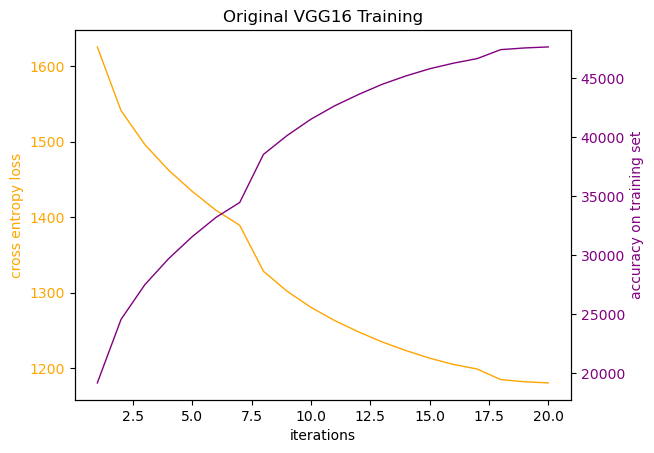

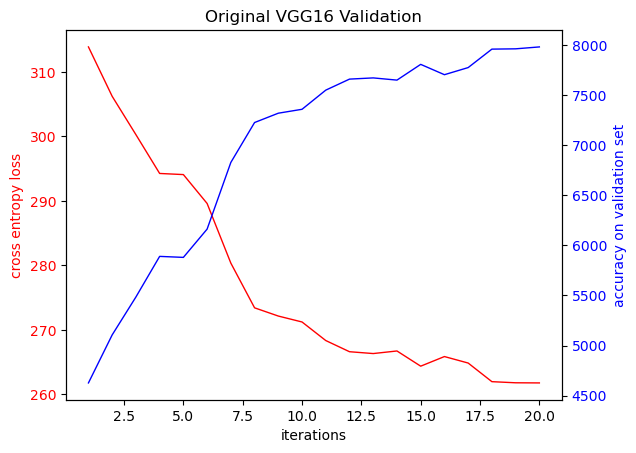

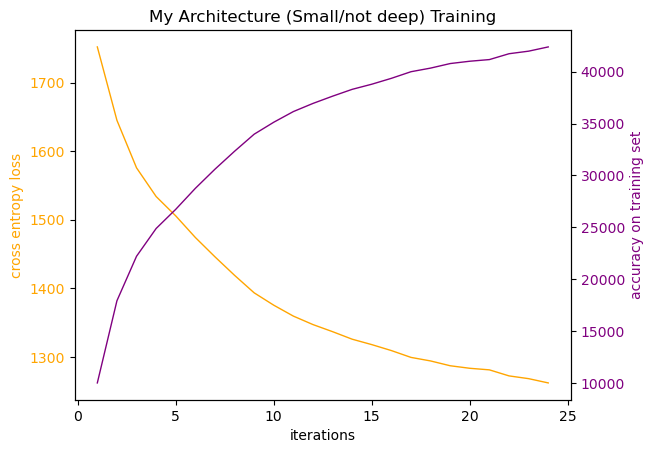

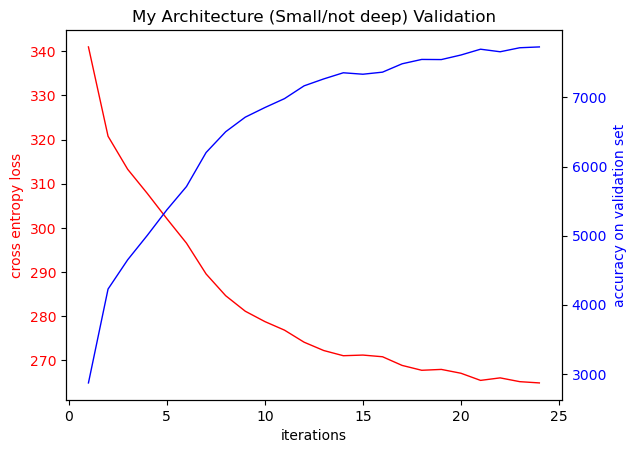

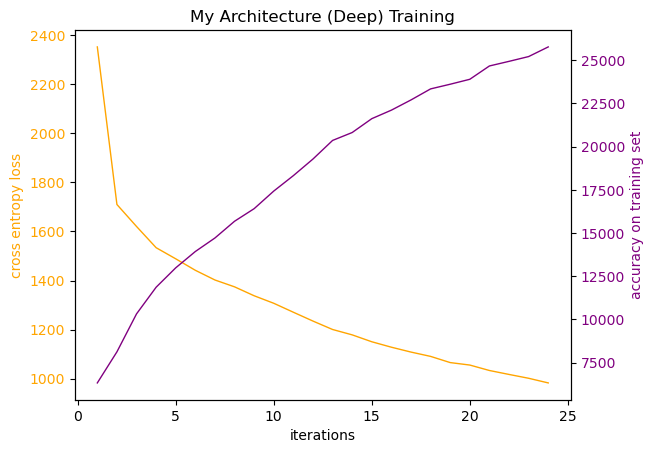

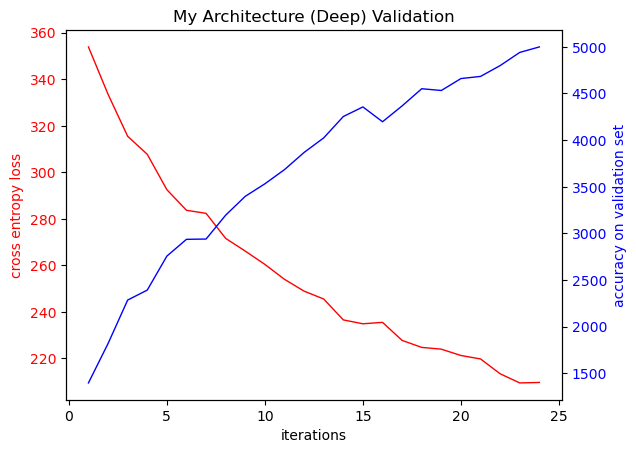

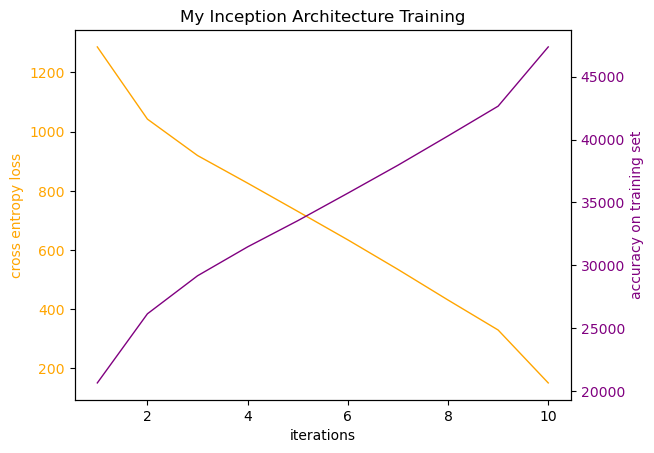

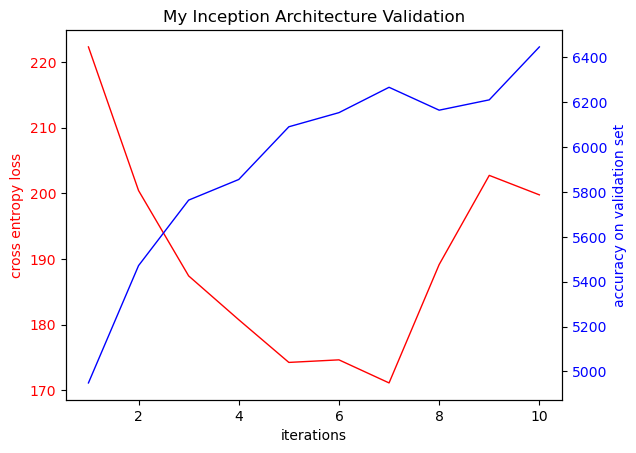

In [34]:
for model in models:
    graph_loss_and_accuracy_training(model['train_losses'], model['train_accs'], model['plot_title']+ " Training")
    graph_loss_and_accuracy_validation(model['val_losses'], model['val_accs'], model['plot_title']+ " Validation")

### Superposition

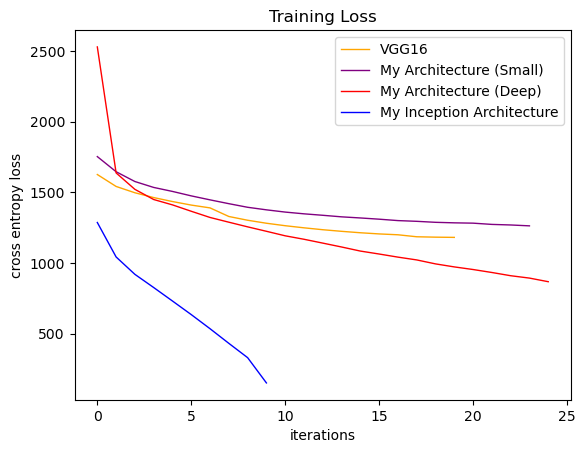

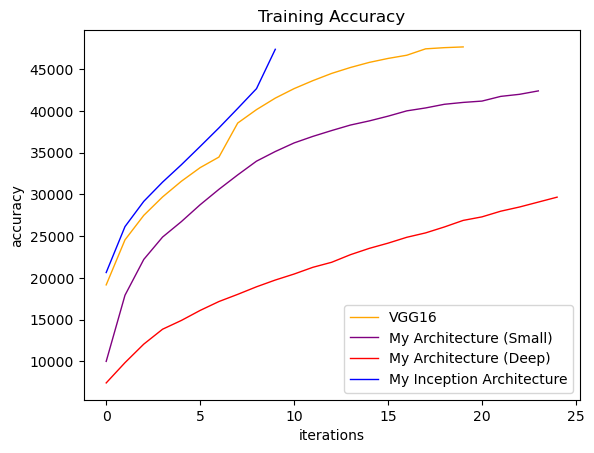

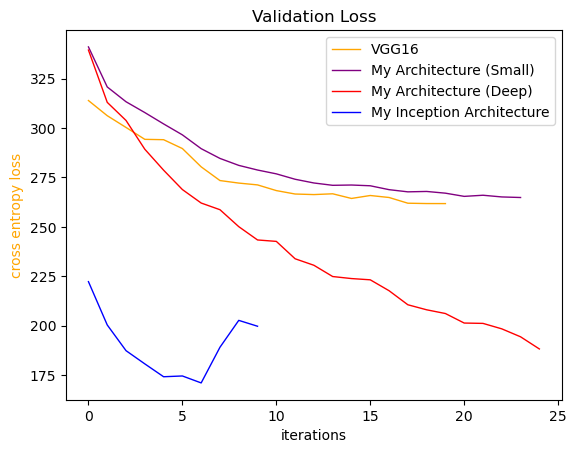

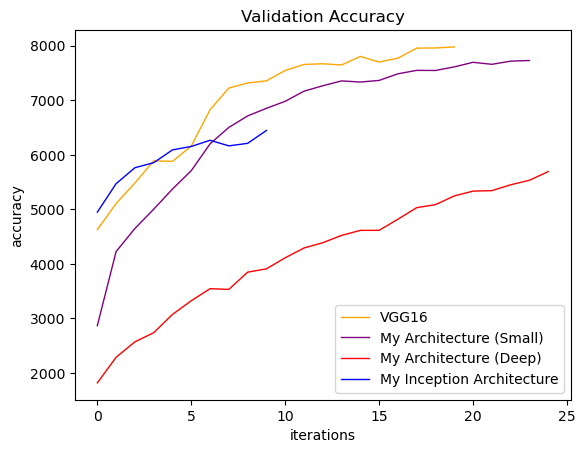

In [10]:
losses_train = [vgg16['train_losses'], my_archi_small['train_losses'], my_archi_deep['train_losses'], my_inception['train_losses']]
accuracies_train = [vgg16['train_accs'], my_archi_small['train_accs'], my_archi_deep['train_accs'], my_inception['train_accs']]
losses_val = [vgg16['val_losses'], my_archi_small['val_losses'], my_archi_deep['val_losses'], my_inception['val_losses']]
accuracies_val = [vgg16['val_accs'], my_archi_small['val_accs'], my_archi_deep['val_accs'], my_inception['val_accs']]

# losses train
fig, ax1 = plt.subplots()
plt.title("Training Loss")
color_ax1 = 'orange'
color_ax2 = 'purple'
color_ax3 = 'red'
color_ax4 = 'blue'
linewidth = 1
ax1.set_xlabel('iterations')
ax1.set_ylabel('cross entropy loss')
ax1.plot(np.arange(len(losses_train[0])), losses_train[0], color=color_ax1, linewidth=linewidth)
ax1.plot(np.arange(len(losses_train[1])), losses_train[1], color=color_ax2, linewidth=linewidth)
ax1.plot(np.arange(len(losses_train[2])), losses_train[2], color=color_ax3, linewidth=linewidth)
ax1.plot(np.arange(len(losses_train[3])), losses_train[3], color=color_ax4, linewidth=linewidth)
ax1.tick_params(axis='y')
plt.legend(["VGG16", "My Architecture (Small)", "My Architecture (Deep)", "My Inception Architecture"])
plt.show()

# accuracies train
fig, ax1 = plt.subplots()
plt.title("Training Accuracy")
color_ax1 = 'orange'
color_ax2 = 'purple'
color_ax3 = 'red'
color_ax4 = 'blue'
linewidth = 1
ax1.set_xlabel('iterations')
ax1.set_ylabel('accuracy')
ax1.plot(np.arange(len(accuracies_train[0])), accuracies_train[0], color=color_ax1, linewidth=linewidth)
ax1.plot(np.arange(len(accuracies_train[1])), accuracies_train[1], color=color_ax2, linewidth=linewidth)
ax1.plot(np.arange(len(accuracies_train[2])), accuracies_train[2], color=color_ax3, linewidth=linewidth)
ax1.plot(np.arange(len(accuracies_train[3])), accuracies_train[3], color=color_ax4, linewidth=linewidth)
ax1.tick_params(axis='y')
plt.legend(["VGG16", "My Architecture (Small)", "My Architecture (Deep)", "My Inception Architecture"])
plt.show()

# losses val
fig, ax1 = plt.subplots()
plt.title("Validation Loss")
color_ax1 = 'orange'
color_ax2 = 'purple'
color_ax3 = 'red'
color_ax4 = 'blue'
linewidth = 1
ax1.set_xlabel('iterations')
ax1.set_ylabel('cross entropy loss', color=color_ax1)
ax1.plot(np.arange(len(losses_val[0])), losses_val[0], color=color_ax1, linewidth=linewidth)
ax1.plot(np.arange(len(losses_val[1])), losses_val[1], color=color_ax2, linewidth=linewidth)
ax1.plot(np.arange(len(losses_val[2])), losses_val[2], color=color_ax3, linewidth=linewidth)
ax1.plot(np.arange(len(losses_val[3])), losses_val[3], color=color_ax4, linewidth=linewidth)
ax1.tick_params(axis='y')
plt.legend(["VGG16", "My Architecture (Small)", "My Architecture (Deep)", "My Inception Architecture"])
plt.show()

# accuracies val
fig, ax1 = plt.subplots()
plt.title("Validation Accuracy")
color_ax1 = 'orange'
color_ax2 = 'purple'
color_ax3 = 'red'
color_ax4 = 'blue'
linewidth = 1
ax1.set_xlabel('iterations')
ax1.set_ylabel('accuracy')
ax1.plot(np.arange(len(accuracies_val[0])), accuracies_val[0], color=color_ax1, linewidth=linewidth)
ax1.plot(np.arange(len(accuracies_val[1])), accuracies_val[1], color=color_ax2, linewidth=linewidth)
ax1.plot(np.arange(len(accuracies_val[2])), accuracies_val[2], color=color_ax3, linewidth=linewidth)
ax1.plot(np.arange(len(accuracies_val[3])), accuracies_val[3], color=color_ax4, linewidth=linewidth)
ax1.tick_params(axis='y')
plt.legend(["VGG16", "My Architecture (Small)", "My Architecture (Deep)", "My Inception Architecture"])
plt.show()

## 3.8 - 3.9


In [49]:
# load model
save = torch.load("./models/VGG16.pt")
model = VGG16(
    activation_str="relu",
    )
model.load_state_dict(save['model_state_dict'])
model.to(device)

VGG16(
  (conv_layer_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_layer_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_layer_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_layer_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_layer_5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_layer_6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_layer_7): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_layer_8): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_layer_9): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_layer_10): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_layer_11): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_layer_12): Conv2d(512, 512, kernel_size=(3,

### VGG16 first layer filters

In [16]:
filters_first = model.get_first_conv_layer_filters()
filters_first = (filters_first - filters_first.min()) / (filters_first.max() - filters_first.min())
print(filters_first.shape)

(64, 3, 3, 3)


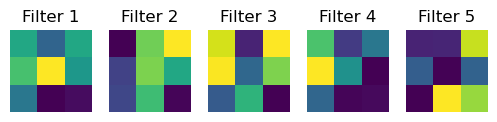

In [64]:
plt.figure(figsize=(10, 10))
for i in range(5):
    plt.subplot(8, 8, i + 1)
    plt.title(f'Filter {i+1}')
    plt.imshow(filters_first[i][0], cmap='viridis')
    plt.axis('off')
plt.show()

### VGG16 Last layer filters

In [18]:
filters_last = model.get_last_conv_layer_filters()
averaged_filters = np.mean(filters_last, axis=1)
print(filters_last.shape)

(512, 512, 3, 3)


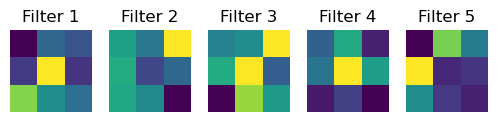

In [65]:
plt.figure(figsize=(10, 10))
for i in range(5):
    plt.subplot(8, 8, i + 1)
    plt.title(f'Filter {i+1}')
    plt.imshow(averaged_filters[i], cmap='viridis')
    plt.axis('off')

In [25]:
train_loader, val_loader = get_cifar10()

Files already downloaded and verified
Files already downloaded and verified


torch.Size([1, 3, 227, 227])


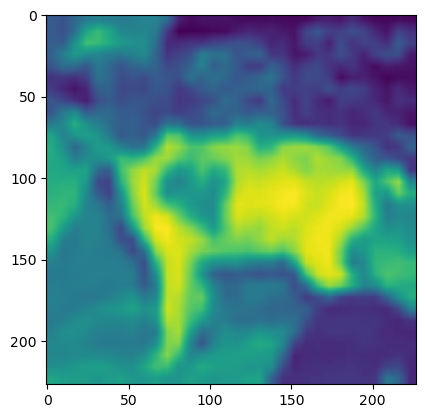

In [41]:
if __name__ == "__main__":
  vis_image = None
  for data, labels in val_loader:
    vis_image = data[12].unsqueeze(0)
    break

  print(vis_image.shape)
  plt.imshow(vis_image[0][1], cmap='viridis')
  

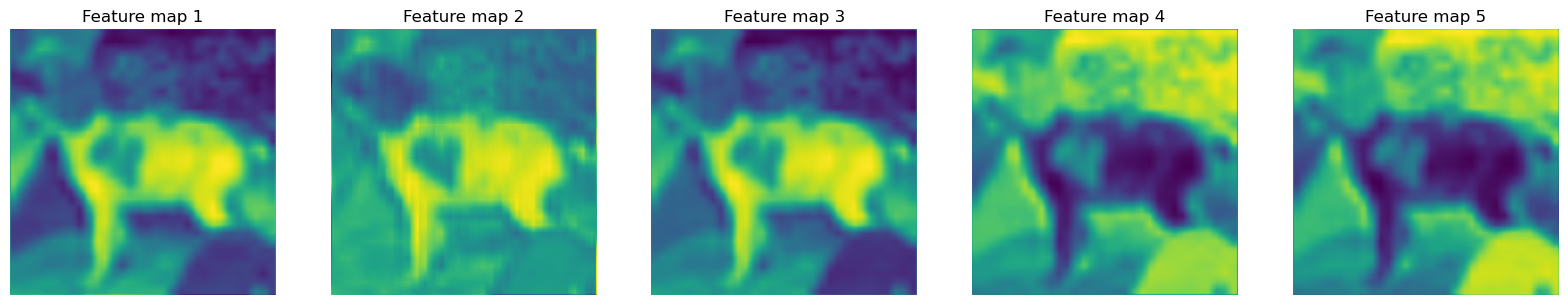

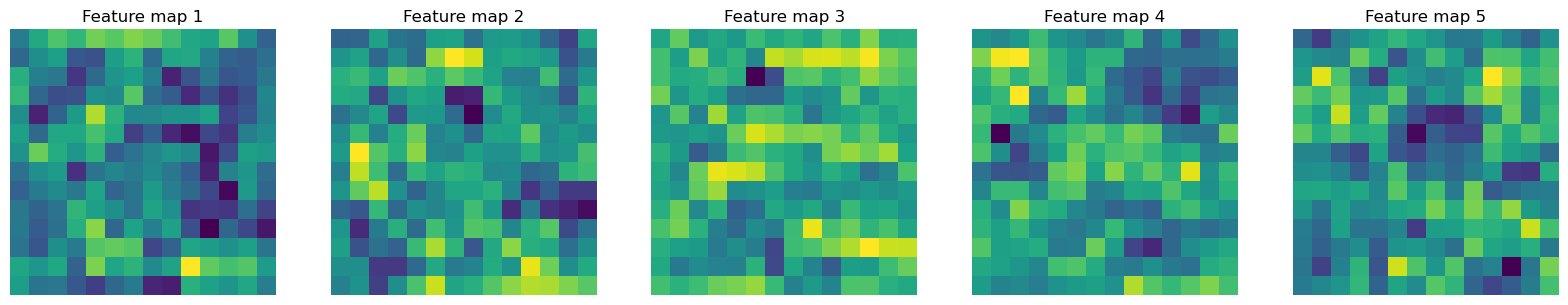

In [66]:
first_layer_maps = []
last_layer_maps = []

def first_hook_fn(module, input, output):
    first_layer_maps.append(output)

def last_hook_fn(module, input, output):
    last_layer_maps.append(output)

first_hook = model.conv_layer_1_bn.register_forward_hook(first_hook_fn)
last_hook = model.conv_layer_13_bn.register_forward_hook(last_hook_fn)

model(vis_image.to(device))

plt.figure(figsize=(20, 20))
for i in range(5):
    plt.subplot(5, 5, i + 1)
    plt.title(f'Feature map {i+1}')
    plt.imshow(first_layer_maps[0][0][i].clone().cpu().detach().numpy(), cmap='viridis')
    plt.axis('off')
plt.show()

plt.figure(figsize=(20, 20))
for i in range(5):
    plt.subplot(5, 5, i + 1)
    plt.title(f'Feature map {i+1}')
    plt.imshow(last_layer_maps[0][0][i].clone().cpu().detach().numpy(), cmap='viridis')
    plt.axis('off')
plt.show()


## 3.10


In [50]:
conv_params = [ layer.shape[0]*layer.shape[2]*layer.shape[3] for layer in model.parameters() if len(layer.shape) == 4 ]
print(conv_params)

fc_params = [
    (4608, 4608),
    (4608, 4608),
    (4608, 10)
]

bn_params = [
    64, 64, 128, 128, 256, 256, 256, 512, 512, 512, 512, 512, 512
]

total = sum(p.numel() for p in model.parameters() if p.requires_grad)
total

[576, 576, 1152, 1152, 2304, 2304, 2304, 4608, 4608, 4608, 4608, 4608, 4608]


134309962

In [51]:
class VGG16_MLP(nn.Module):
    def __init__(self):
        super(VGG16_MLP, self).__init__()

        self.fc_input = nn.Linear(3072, conv_params[0])
        self.bn_input = nn.BatchNorm1d(conv_params[0])

        self.fc2 = nn.Linear(conv_params[0], conv_params[1])
        self.bn2 = nn.BatchNorm1d(conv_params[1])

        self.fc3 = nn.Linear(conv_params[1],conv_params[2])
        self.bn3 = nn.BatchNorm1d(conv_params[2])

        self.fc4 = nn.Linear(conv_params[2], conv_params[3])
        self.bn4 = nn.BatchNorm1d(conv_params[3])

        self.fc5 = nn.Linear(conv_params[3], conv_params[4])
        self.bn5 = nn.BatchNorm1d(conv_params[4])

        self.fc6 = nn.Linear(conv_params[4], conv_params[5])
        self.bn6 = nn.BatchNorm1d(conv_params[5])

        self.fc7 = nn.Linear(conv_params[5], conv_params[6])
        self.bn7 = nn.BatchNorm1d(conv_params[6])

        self.fc8 = nn.Linear(conv_params[6], conv_params[7])
        self.bn8 = nn.BatchNorm1d(conv_params[7])

        self.fc9 = nn.Linear(conv_params[7], conv_params[8])
        self.bn9 = nn.BatchNorm1d(conv_params[8])

        self.fc10 = nn.Linear(conv_params[8], conv_params[9])
        self.bn10 = nn.BatchNorm1d(conv_params[9])

        self.fc11 = nn.Linear(conv_params[9], conv_params[10])
        self.bn11 = nn.BatchNorm1d(conv_params[10])

        self.fc12 = nn.Linear(conv_params[10], conv_params[11])
        self.bn12 = nn.BatchNorm1d(conv_params[11])

        self.fc13 = nn.Linear(conv_params[11], conv_params[12])
        self.bn13 = nn.BatchNorm1d(conv_params[12])

        self.fc14 = nn.Linear(fc_params[0][0], fc_params[0][1])
        self.fc15 = nn.Linear(fc_params[1][0], fc_params[1][1])
        self.fc_out = nn.Linear(fc_params[2][0], fc_params[2][1])

    def forward(self, x):
        x = x.view(x.size(0), -1)

        x = F.relu(self.bn_input(self.fc_input(x)))

        x = F.relu(self.bn2(self.fc2(x)))
        x = F.relu(self.bn3(self.fc3(x)))
        x = F.relu(self.bn4(self.fc4(x)))
        x = F.relu(self.bn5(self.fc5(x)))
        x = F.relu(self.bn6(self.fc6(x)))
        x = F.relu(self.bn7(self.fc7(x)))
        x = F.relu(self.bn8(self.fc8(x)))
        x = F.relu(self.bn9(self.fc9(x)))
        x = F.relu(self.bn10(self.fc10(x)))
        x = F.relu(self.bn11(self.fc11(x)))
        x = F.relu(self.bn12(self.fc12(x)))
        x = F.relu(self.bn13(self.fc13(x)))
        x = F.relu(self.fc14(x))
        x = F.relu(self.fc15(x))


        x = F.softmax(self.fc_out(x), dim=1)
        return x

In [16]:
def get_cifar10():
  normalize = transforms.Normalize(
      mean=[0.4914, 0.4822, 0.4465],
      std=[0.2023, 0.1994, 0.2010],
  )

  # define transforms
  transform = transforms.Compose([
          transforms.Resize((32,32)),
          transforms.ToTensor(),
          normalize,
  ])

  train_dataset = torchvision.datasets.CIFAR10(
      root='./data', train=True, download=True, transform=transform)
  train_loader = torch.utils.data.DataLoader(
      train_dataset, batch_size=64, shuffle=True, num_workers=2)

  val_dataset = torchvision.datasets.CIFAR10(
      root='./data', train=False, download=True, transform=transform)
  val_loader = torch.utils.data.DataLoader(
      val_dataset, batch_size=64, shuffle=False, num_workers=2)

  return train_loader, val_loader

def train_loop(epoch, model, train_loader, criterion, optimizer):
  train_acc = 0.
  train_loss = 0.

  for x, y in train_loader:
    x, y = x.to(device), y.to(device)

    optimizer.zero_grad()
    y_hat = model.forward(x)
    loss = criterion(y_hat, y)
    loss.backward()
    optimizer.step()

    train_acc += (y_hat.argmax(axis=-1) == y).sum().item()
    train_loss += loss.item()

  print(f"Epoch: {epoch} | Train Acc: {train_acc:.6f} | Train Loss: {train_loss:.6f}")
  return train_acc, train_loss

def valid_loop(epoch, model, val_loader, criterion):
  val_acc = 0.
  val_loss = 0.

  for x, y in val_loader:
    x, y = x.to(device), y.to(device)

    y_hat = model.forward(x)
    loss = criterion(y_hat, y)

    val_acc += (y_hat.argmax(axis=-1) == y).sum().item()
    val_loss += loss.item()

  print(f"Epoch: {epoch} | Val Acc: {val_acc:.6f}   | Val Loss: {val_loss:.6f}")
  return val_acc, val_loss

In [ ]:
if __name__ == "__main__":
  activation_str = "relu"
  train_accs, train_losses, val_accs, val_losses = [], [], [], []
  n_epochs = 25

  model_path = "./models/VGG_MLP.pt"
  model = VGG16_MLP().to(device)

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

  train_loader, val_loader = get_cifar10()

  best = 0
  count = 0
  lr_reductions =0

  patience_lr = 1
  factor = 0.1
  scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=factor, patience=patience_lr, verbose=True)

  for epoch in tqdm(range(n_epochs)):
    # Training
    train_acc, train_loss = train_loop(epoch, model, train_loader, criterion, optimizer)
    train_accs.append(train_acc)
    train_losses.append(train_loss)

    # Validation
    val_acc, val_loss = valid_loop(epoch, model, val_loader, criterion)
    val_accs.append(val_acc)
    val_losses.append(val_loss)

    scheduler.step(val_acc)

    # early stopping
    if val_acc >= best:
        best = val_acc
        count = 0

        save = {
          'model_state_dict': model.state_dict(),
          'train_losses': train_losses,
          'val_losses': val_losses,
          'train_accs': train_accs,
          'val_accs': val_accs
        }

        os.makedirs("./models/", exist_ok=True)
        torch.save(save, model_path)
    else:
        count += 1
        if count == 5:
            print("Stopping early. Accuracy hasn't improved")
            save = torch.load(model_path)
            model.load_state_dict(save['model_state_dict'])
            model.to(device)
            break

    for param_group in optimizer.param_groups:
        if param_group['lr'] == 0.001 * (factor ** (lr_reductions + 1)):
            lr_reductions += 1

    if lr_reductions == 3:
        print("Stopping early. Learning rate hasn't improved")
        break

### Plotting MLP

In [35]:
vgg16_mlp_save = torch.load("./models/VGG_MLP.pt")
vgg16_mlp = {
          'plot_title' : "VGG16 MLP",
          'train_losses': vgg16_mlp_save['train_losses'],
          'val_losses': vgg16_mlp_save['val_losses'],
          'train_accs': vgg16_mlp_save['train_accs'],
          'val_accs': vgg16_mlp_save['val_accs']
        }

In [36]:
models = [vgg16, vgg16_mlp]

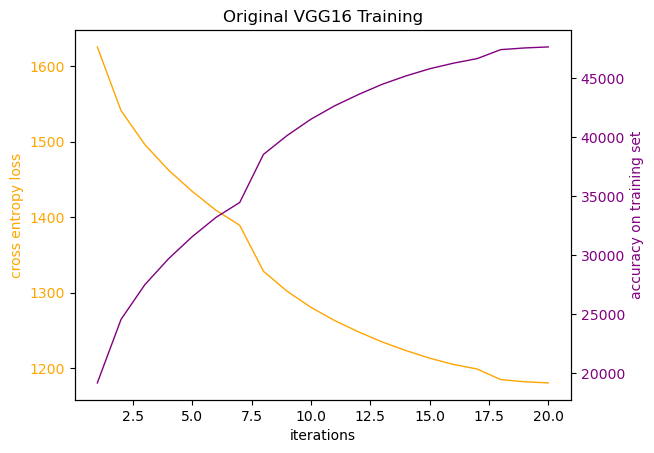

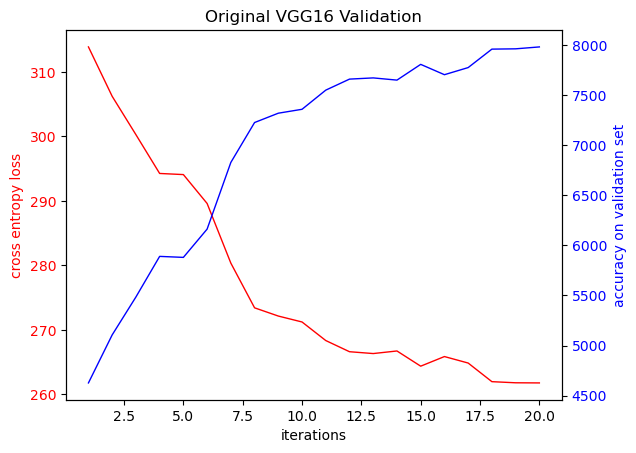

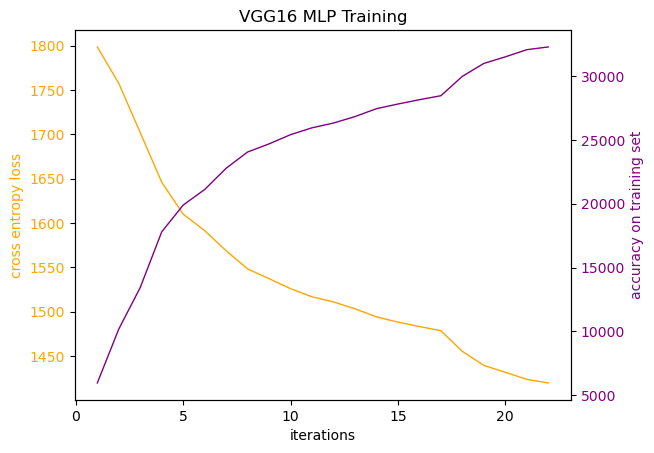

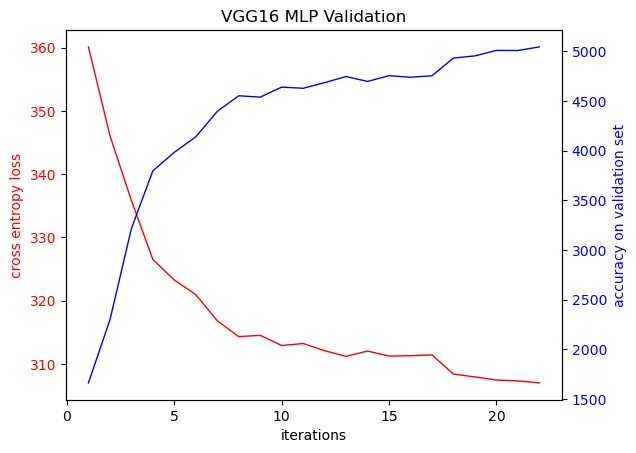

In [37]:
for model in models:
    graph_loss_and_accuracy_training(model['train_losses'], model['train_accs'], model['plot_title']+ " Training")
    graph_loss_and_accuracy_validation(model['val_losses'], model['val_accs'], model['plot_title']+ " Validation")

### Stats MLP

In [52]:
loss_mean = np.mean(vgg16_mlp['val_losses'])
loss_std = np.std(vgg16_mlp['val_losses'])
acc_mean = np.mean(vgg16_mlp['val_accs'])
acc_std = np.std(vgg16_mlp['val_accs'])
print(f"Loss mean: {loss_mean:.6f} | Loss std: {loss_std:.6f} | Accuracy mean: {acc_mean:.6f} | Accuracy std: {acc_std:.6f}")

vgg16_mlp_model = VGG16_MLP().to(device)
vgg16_mlp_model.load_state_dict(vgg16_mlp_save['model_state_dict'])
nb_params = sum(p.numel() for p in vgg16_mlp_model.parameters() if p.requires_grad)
print(f"Number of parameters: {nb_params}")

Loss mean: 317.807436 | Loss std: 13.245139 | Accuracy mean: 4324.409091 | Accuracy std: 861.684326
Number of parameters: 176784778


### Stats VGG16

In [55]:
loss_mean = np.mean(vgg16['val_losses'])
loss_std = np.std(vgg16['val_losses'])
acc_mean = np.mean(vgg16['val_accs'])
acc_std = np.std(vgg16['val_accs'])
print(f"Loss mean: {loss_mean:.6f} | Loss std: {loss_std:.6f} | Accuracy mean: {acc_mean:.6f} | Accuracy std: {acc_std:.6f}")

vgg16_model = VGG16(
    activation_str="relu",
    )
vgg16_model.load_state_dict(vgg16_save['model_state_dict'])
nb_params = sum(p.numel() for p in vgg16_model.parameters() if p.requires_grad)
print(f"Number of parameters: {nb_params}")

Loss mean: 277.210844 | Loss std: 15.978636 | Accuracy mean: 6978.950000 | Accuracy std: 1027.871270
Number of parameters: 134309962
